In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [111]:
# READ DATA

ticker = 'ACA-USDT'
start_date = "2022-06-01"
end_date = "2022-10-01"

all_files = os.listdir("binance/")  
column_names = [f"{filename.split('.')[0]}_{ticker}" for filename in all_files]

dataset = pd.concat(
    [pd.read_parquet(f"binance/{filename}")
     [ticker]
     [start_date:end_date]
    for filename in all_files], 
    keys=column_names, 
    axis=1)

dataset.shape

(5904, 75)

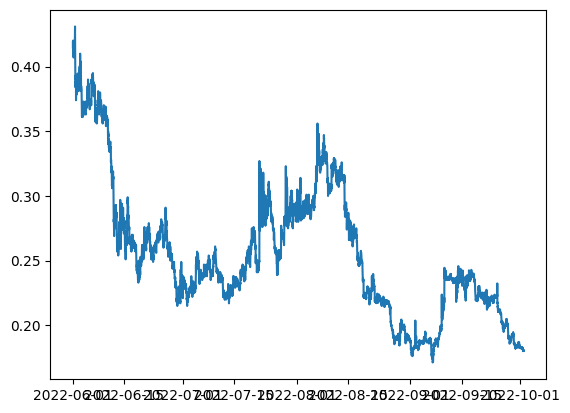

In [112]:
# TICKER FOR MODEL

plt.plot(dataset['close_ACA-USDT'])

In [113]:
# MAKE STATIONARY DATASET

stationary_dataset = pd.DataFrame()

for column_name in dataset.columns:
    if "size" in column_name or "count" in column_name or "volume" in column_name:
        stationary_dataset[f"{column_name}_log1"] = np.log(dataset[column_name]+1)

    elif column_name in [f"open_{ticker}", f"high_{ticker}", f"low_{ticker}", f"close_{ticker}", f"vwap_{ticker}"]: 
        stationary_dataset[f"{column_name}_pct"] = dataset[column_name].pct_change()
    
    elif "_vwap_" in column_name:
        stationary_dataset[f"{column_name}_pct"] = dataset[column_name].pct_change()
        
    elif "hh" in column_name: 
        stationary_dataset[column_name] = dataset[column_name]

    
stationary_dataset["best_price_spread_ema"] = (dataset[f"best_bid_{ticker}"] - dataset[f"best_ask_{ticker}"]).ewm(span=4, adjust=False).mean()
stationary_dataset["max_price_spread_ema"] = (dataset[f"bid_high_{ticker}"] - dataset[f"ask_low_{ticker}"]).ewm(span=4, adjust=False).mean()
stationary_dataset["min_price_spread_ema"] = (dataset[f"bid_low_{ticker}"] - dataset[f"ask_high_{ticker}"]).ewm(span=4, adjust=False).mean()

stationary_dataset = stationary_dataset.iloc[1:] # we need this after pct_change

# ADD TARGET TO DATASET
stationary_dataset['TARGET'] = stationary_dataset[f"vwap_{ticker}_pct"].shift(-1)
stationary_dataset = stationary_dataset.iloc[:-1] # we need this after shifting

# SAVE DATASET
# stationary_dataset.to_parquet("stationary_dataset.gzip", compression='gzip')

LSTM NEURAL NETWORK

In [114]:
params = dict(
    input_dim = stationary_dataset.shape[1]-1,
    hidden_dim = (stationary_dataset.shape[1]-1) // 4,
    output_dim = 1,
    batch_size = 10,
    learning_rate = 1e-3,
    epochs = 5,
    train_test_split = stationary_dataset.loc[stationary_dataset.index < "2022-09-01"].shape[0]
)

In [115]:
# MODEL DATA STRUCTURE

class model_dataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.input_data, self.feature_number = self.data.shape

    def __len__(self):
        return self.input_data

    def __getitem__(self, idx):
        return self.data[idx,:-1], self.data[idx,-1].unsqueeze_(1)
    
# LSTM NEURAL NETWORK

class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

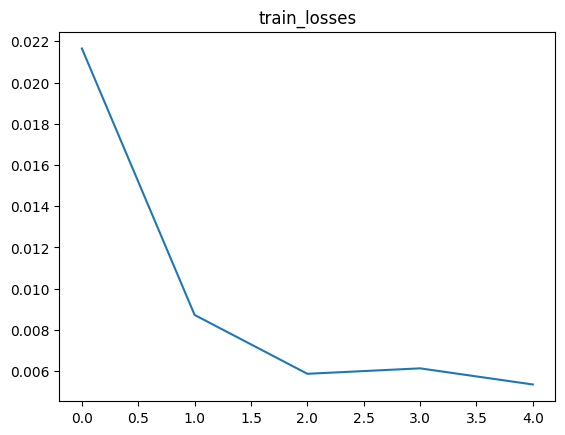

test_loss: 0.01


In [117]:
# TRAINING & PREDICTION

m_dataset = model_dataset(stationary_dataset.values)

lstm_model = LSTM_Model(params['input_dim'], params['hidden_dim'], params['output_dim'])
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=params['learning_rate'])

train_losses = []
test_losses = []
predicted_return = []


X_train, y_train = m_dataset[:params['train_test_split']]
X_test, y_test = m_dataset[params['train_test_split']:]

# TRAIN
for _ in range(params['epochs']):
    lstm_model.train()
    optimizer.zero_grad()

    train_predicted_target = lstm_model(X_train)
    train_loss = criterion(train_predicted_target, y_train)
    train_losses.append(train_loss.item())

    train_loss.backward()
    optimizer.step()
    lstm_model.eval()

plt.plot(train_losses)
plt.title("train_losses")
plt.show()


# TEST
with torch.no_grad():
    test_predicted_target = lstm_model(X_test)
    test_loss = criterion(test_predicted_target, y_test)
    print("test_loss: {}".format(np.round(float(test_loss), 2)))

# SAVE PREDICTED RETURN
#pd.DataFrame(test_predicted_target, index=stationary_dataset["2022-09-01":].index).to_parquet(f"nn_predicted_returns/{ticker}.gzip")
